# Decision Tree Model Analysis Walkthrough (Dynamic Rollover)

Decision Trees are a type of supervised machine learning algorithm that is mostly used for classification problems. The main advantage of this model is its interpretability, where decisions are made based on asking a series of questions. This notebook will walk you through the process of training and evaluating a Decision Tree model on the dynamic rollover dataset.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from pathlib import Path

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('../data')

with open(path / 'dynamic_rollover_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

## Dataset Splitting
We begin by splitting our dataset into a training and testing set. This process ensures that we have a distinct set of data to evaluate the model's performance.

In [3]:
# define independent variables and dependent variable
maneuver = 'Dynamic Rollover'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Build and Fit the Model
We will set up a parameter grid with the best parameters. These parameters were developed in the modeling directory in the decision tree (dynamic rollover) file. For more information on the training and tuning of this model please refer to the modeling file.

In [5]:
params = {
    'max_depth': None,
    'min_samples_split': 5,
    'criterion': 'entropy',
    'splitter': 'best',
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': 42
}

In [6]:
clf = DecisionTreeClassifier(**params)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features='sqrt', min_samples_split=5,
                       random_state=42)

## Make Predictions for Model Evaluation

In [7]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9999    1.0000    1.0000     51270
           1     0.9980    0.9941    0.9961       511

    accuracy                         0.9999     51781
   macro avg     0.9990    0.9971    0.9980     51781
weighted avg     0.9999    0.9999    0.9999     51781



In [8]:
print(confusion_matrix(y_test, y_pred))

[[51269     1]
 [    3   508]]


## Visualizations
These visualizations will provide a comprehensive understanding of the model's performance, the features that drive decisions, and how the model's performance evolves as more data is added.

### ROC Curve
The Receiver Operating Characteristic (ROC) Curve is a graphical representation that showcases the diagnostic ability of a binary classifier as its discrimination threshold varies. The ROC curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

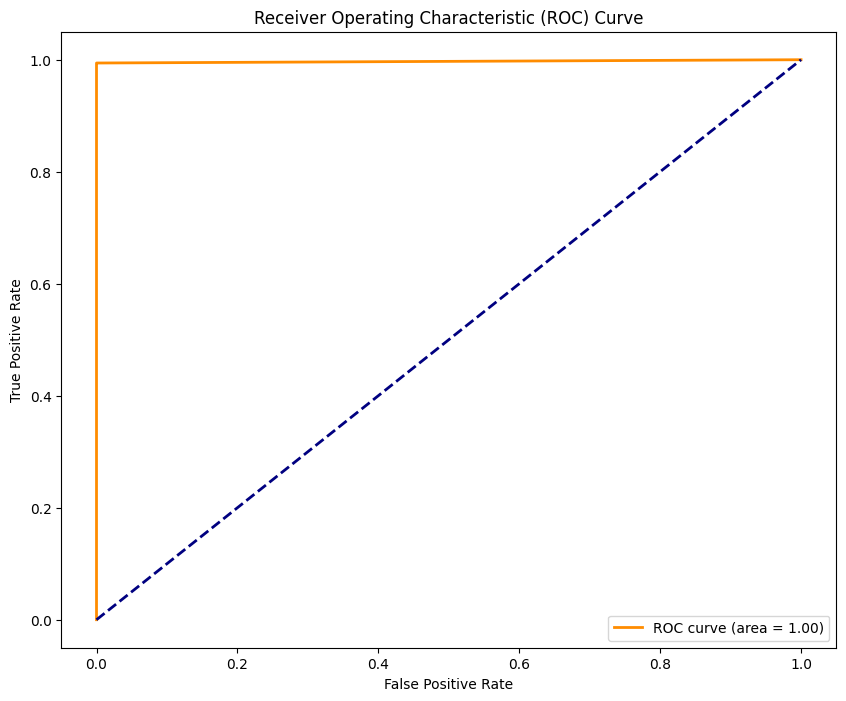

In [9]:
# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Importances

Feature importances provide insights into which variables or features have the most influence in making a decision in a machine learning model. In the context of decision trees and ensemble methods based on trees, like random forests, feature importance is computed by looking at the splits in the trees. 

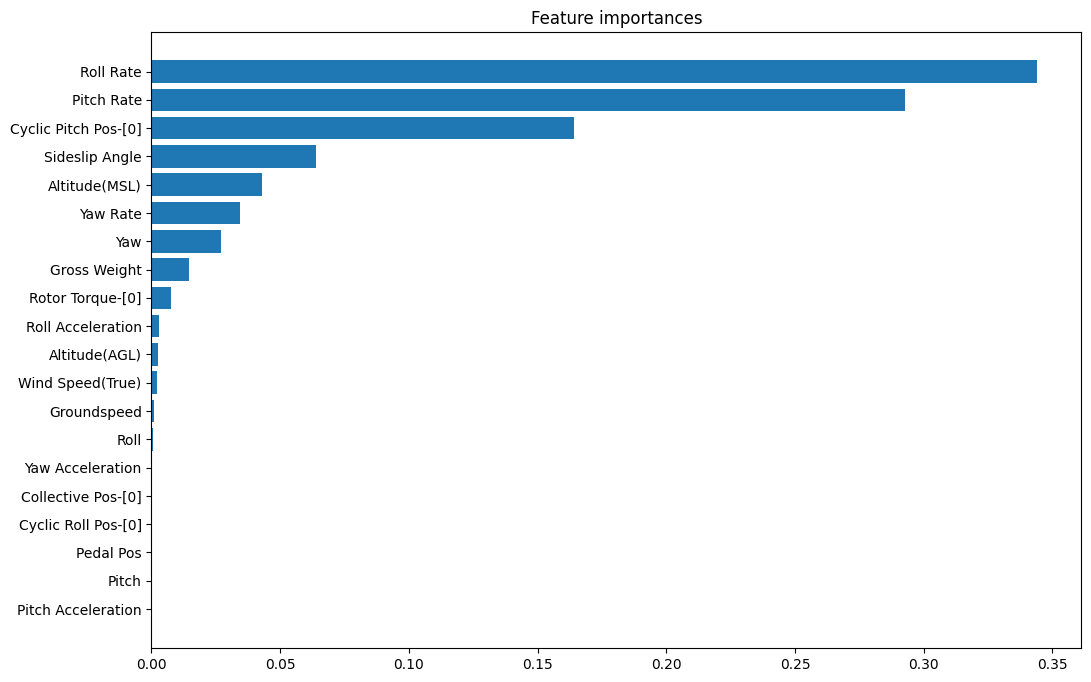

In [10]:
# retrieve feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()


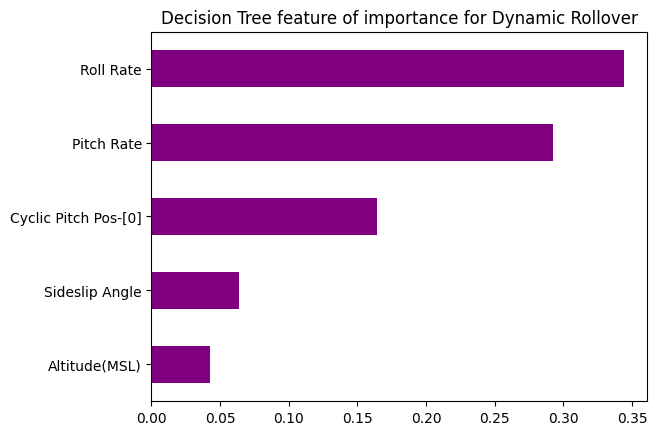

In [11]:
#Plotting the feature of importance
#nlargest(n) is a pandas Series method which will return a subset of the series with the largest n values. 
#This is useful if you've got lots of features in your model and you only want to plot the most important.
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(5)
   .plot(kind='barh', color="purple", align="center", 
    title=f"Decision Tree feature of importance for {maneuver}").invert_yaxis())

## Model Evaluation Summary:

### ROC Curve Analysis:
Our Decision Tree model demonstrates excellent performance, with an F1 score of 1.0 on the ROC curve. This score indicates a perfect balance between precision and recall. In real-world terms, this suggests that the model is capable of distinguishing between the classes without any errors.

### Feature Importance Analysis:
- Roll Rate (0.35 importance): This is the most influential variable in our dataset, contributing the most to the model's decision-making process.
- Pitch Rate (0.3 importance): Closely following Roll Rate, Pitch Rate also plays a significant role in the model's predictions.
- Cyclic Pitch Pos [0] (0.17 importance): While less impactful than Roll Rate and Pitch Rate, Cyclic Pitch Pos [0] still holds considerable importance.
- Sideslip Angle (0.07 importance): Its influence is moderate but can't be ignored.
- Altitude (MSL) (0.04 importance): It has the least impact among the top 5 features but might still offer some insights.

Given the feature importance distribution, we can infer that Roll Rate and Pitch Rate are the primary drivers for the model's predictions, with Cyclic Pitch Pos [0] also playing a noticeable role. Sideslip Angle and Altitude (MSL) have lesser importance but can provide supplementary information.